## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
# install tensorflow==2.6.0rc0

%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["THEANO_FLAGS"]  = "device=cuda0,floatX=float32,force_device=True"
os.environ['CPLUS_INCLUDE_PATH'] = '/usr/local/cuda/include'
import numpy as np
import theano as th
import theano.tensor as T

from tensorflow.python.keras.utils import np_utils
import tensorflow.keras.models as models
from tensorflow.python.keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.python.keras.layers.noise import GaussianNoise
from tensorflow.python.keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
# import cPickle, random, sys, keras
import random, sys
import _pickle as cPickle
import tensorflow


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/home/zehao/anaconda3/bin/../lib/gcc/x86_64-conda_cos6-linux-gnu/7.3.0/../../../../x86_64-conda_cos6-linux-gnu/bin/ld: cannot find -lcudnn\ncollect2: error: ld returned 1 exit status\n'
Mapped name None to device cuda0: NVIDIA GeForce 940MX (0000:01:00.0)


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("/home/zehao/Desktop/HDD/RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    tmpList=list(yy)
    yy1 = np.zeros([len(tmpList), max(tmpList)+1])
    yy1[np.arange(len(tmpList)),tmpList] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [4]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


# Build the NN Model

In [5]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(256, (1,3), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 132, 80)        0

In [11]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
# batch_size = 1024  # training batch size
batch_size = 32  # training batch size

# Train the Model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
3438/3438 - 240s - loss: 1.8824 - val_loss: 1.5374
Epoch 2/100
3438/3438 - 217s - loss: 1.5719 - val_loss: 1.3764
Epoch 3/100
3438/3438 - 232s - loss: 1.4856 - val_loss: 1.3617
Epoch 4/100
3438/3438 - 207s - loss: 1.4559 - val_loss: 1.3313
Epoch 5/100
3438/3438 - 212s - loss: 1.4383 - val_loss: 1.3529
Epoch 6/100
3438/3438 - 206s - loss: 1.4214 - val_loss: 1.3120
Epoch 7/100
3438/3438 - 206s - loss: 1.4063 - val_loss: 1.3285
Epoch 8/100
3438/3438 - 206s - loss: 1.3957 - val_loss: 1.3568
Epoch 9/100
3438/3438 - 207s - loss: 1.3867 - val_loss: 1.3149
Epoch 10/100
3438/3438 - 208s - loss: 1.3778 - val_loss: 1.3134
Epoch 11/100
3438/3438 - 206s - loss: 1.3738 - val_loss: 1.2961
Epoch 12/100
3438/3438 - 206s - loss: 1.3661 - val_loss: 1.3068
Epoch 13/100
3438/3438 - 206s - loss: 1.3605 - val_loss: 1.3137
Epoch 14/100
3438/3438 - 207s - loss: 1.3577 - val_loss: 1.3023
Epoch 15/100
3438/3438 - 207s - loss: 1.3466 - val_loss: 1.2883
Epoch 16/100
3438/3438 - 215s - loss: 1.3415 - va

# Evaluate and Plot Model Performance

In [15]:
# Show simple version of performance
# score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0, batch_size=batch_size)
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)

1.2659624814987183


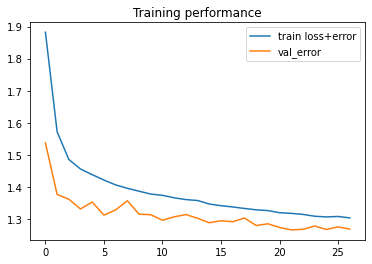

In [16]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [17]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

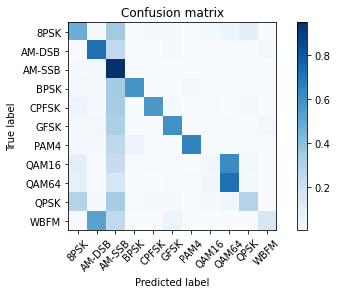

In [18]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
Overall Accuracy:  0.09661482159194877
Overall Accuracy:  0.09391462306993642
Overall Accuracy:  0.09605643994211288
Overall Accuracy:  0.10447491880187658
Overall Accuracy:  0.13509571558796718
Overall Accuracy:  0.22036609205615781
Overall Accuracy:  0.32188131545103804
Overall Accuracy:  0.47947214076246336
Overall Accuracy:  0.5957486136783734
Overall Accuracy:  0.6630986937590712
Overall Accuracy:  0.7153284671532847
Overall Accuracy:  0.7448200654307524
Overall Accuracy:  0.7652349486049926
Overall Accuracy:  0.759927797833935
Overall Accuracy:  0.769341749323715
Overall Accuracy:  0.7761384335154827
Overall Accuracy:  0.7577403585008148
Overall Accuracy:  0.7687765270345082
Overall Accuracy:  0.7628959276018099
Overall Accuracy:  0.7695769576957696


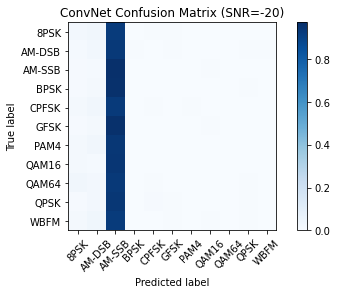

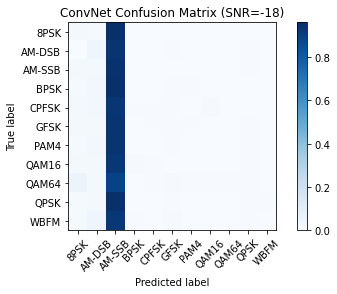

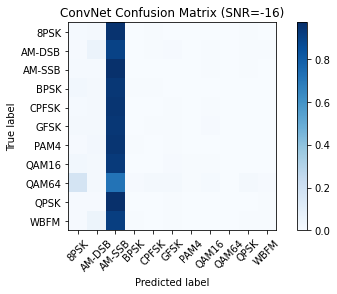

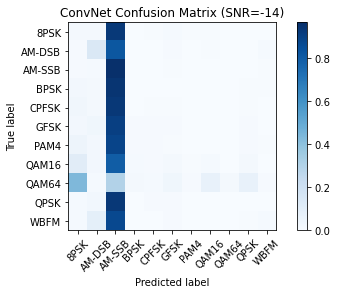

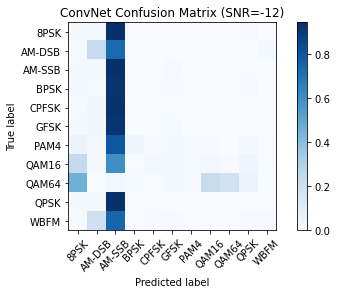

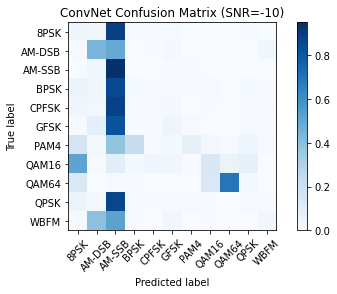

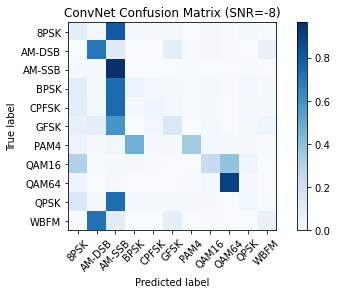

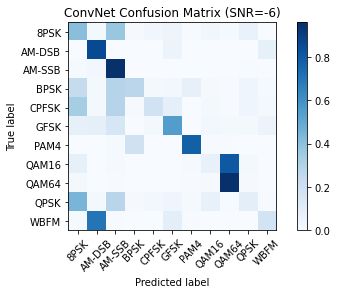

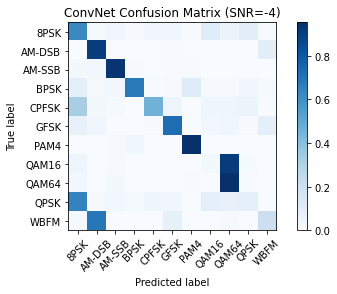

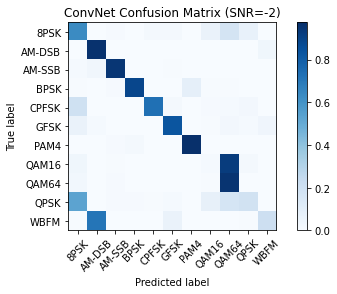

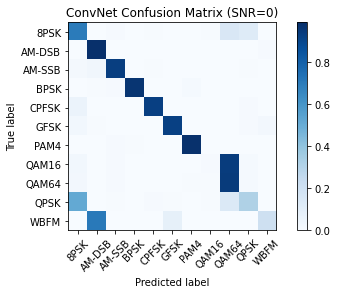

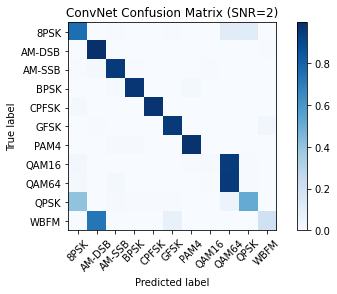

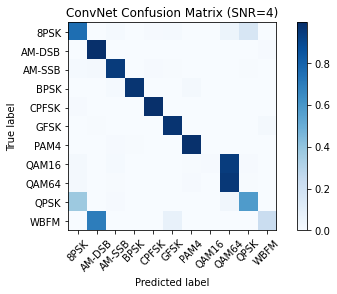

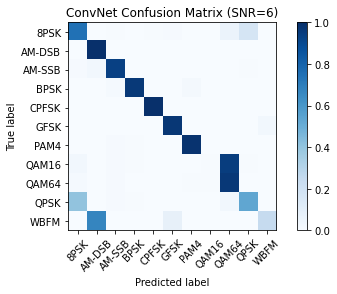

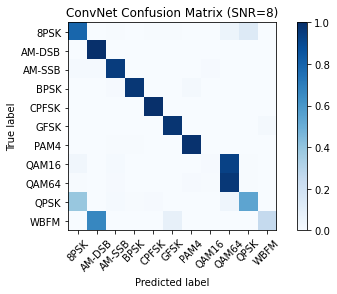

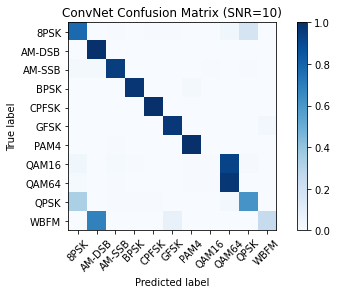

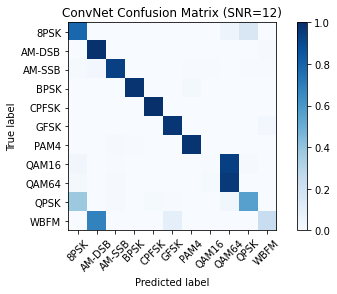

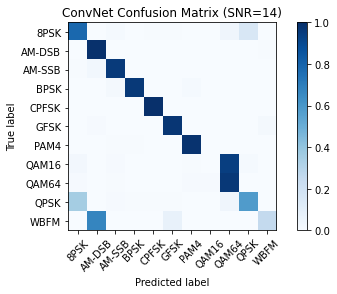

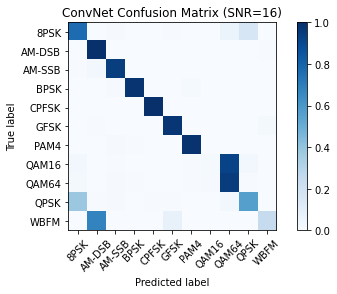

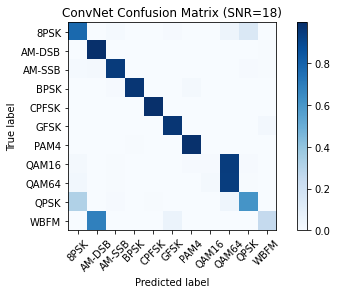

In [34]:
# Plot confusion matrix
acc = {}
print(snrs)
test_SNRs = map(lambda x: lbl[x][1], test_idx)
test_SNRs = np.fromiter(test_SNRs, dtype=int) # convert to numpy array
for snr in snrs:

    # extract classes @ SNR
    test_X_i = X_test[np.where(test_SNRs==snr)]
    test_Y_i = Y_test[np.where(test_SNRs==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [36]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09661482159194877, -18: 0.09391462306993642, -16: 0.09605643994211288, -14: 0.10447491880187658, -12: 0.13509571558796718, -10: 0.22036609205615781, -8: 0.32188131545103804, -6: 0.47947214076246336, -4: 0.5957486136783734, -2: 0.6630986937590712, 0: 0.7153284671532847, 2: 0.7448200654307524, 4: 0.7652349486049926, 6: 0.759927797833935, 8: 0.769341749323715, 10: 0.7761384335154827, 12: 0.7577403585008148, 14: 0.7687765270345082, 16: 0.7628959276018099, 18: 0.7695769576957696}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

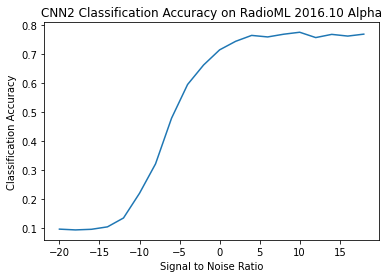

In [38]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")